# Flow Timing Strategy

Quantscience Post replication: https://www.linkedin.com/posts/quant-science_how-to-make-a-simple-algorithmic-trading-activity-7272265251713093632-qIgm

This strategy takes advantage of "flow effects", which is how certain points in time influence the value of an asset. 

We create short entry signals on each new month's 1st and 5th day. 
Similarly, we make long signals 7 days and 1 day before the end of each month. 

### Signals

1. Generate short entry signals on the first day of each new month
2. Generate short exit signals five days after short entry
3. Generate long entry signals seven days before the end of each month
4. Generate long exit signals one day before the end of each month

In [18]:
import traceback
import sys
import os

# Add the parent directory to the Python path to make imports work
sys.path.append(os.path.dirname(os.path.abspath("")))

from MyBTstrategy import MyStrategy
from MyBTengine import run_strategy
import backtrader as bt
import pandas as pd

In [19]:
# import yfinance as yf
# yf.download("SPY", start="2004-01-01", end="2024-12-03",auto_adjust=True).xs("SPY",axis=1,level=1).to_csv("SPY.csv")
# yf.download("TLT", start="2004-01-01", end="2024-12-03",auto_adjust=True).xs("TLT",axis=1,level=1).to_csv("TLT.csv")
tlt=pd.read_csv("TLT.csv",index_col=0,parse_dates=True)
tlt["month"] = tlt.index.month
# get the last day of each month 
tlt["month"] = tlt["month"].diff().shift(-1)

# Incremental range logic
tlt['incremental'] = (tlt['month'] != 0).cumsum()  # Create groups for each reset
tlt['incremental'] = tlt.groupby('incremental').cumcount(ascending=False) +1
tlt['incremental']= tlt['incremental'].shift(1).fillna(0)

In [ ]:
class FlowTimingStrategy(MyStrategy):
    params = {
        'printlog': False,
    }

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.dataopen = self.datas[0].open

        # To keep track of pending orders 
        self.orefs = list()
        self.bit=0

        self.bar_executed = 0
        self.trades=[]

        self.i = 0
        self.end_of_month = tlt[tlt["month"]==1].index

        self.j = 0
        self.day7 = tlt[tlt["incremental"]==9].index
    
    def next(self):
 
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.orefs:
            return
        
        # Get current date
        current_date = self.datas[0].datetime.datetime(0)
        
        # Prevent self.i from exceeding the size of your self.end_of_month array
        # Check if it's first day of month (short entry)
        if self.i < len(self.end_of_month) and current_date.day == self.end_of_month[self.i].day:
            if not self.position:  # If no position is open
                # the order will be executed on the first day open
                self.orefs.append(self.sell(exectype=bt.Order.Close))  # Enter short position
                self.i += 1
                
        # Check if it's 5 days after month start (short exit)
        elif len(self) >= (self.bar_executed + 4):
            if self.position.size < 0:  # If we're in a short position
                self.orefs.append(self.close(exectype=bt.Order.Close))  # Exit short position
        
        # Prevent self.j from exceeding the size of your self.day7 array
        # Check if it's 7 days before month end (long entry)
        if self.j < len(self.day7) and current_date.day == self.day7[self.j].day:
            
            if not self.position:  # If no position is open
                self.orefs.append(self.buy(exectype=bt.Order.Close))  # Enter long position
                self.j += 1
                
        # Check if it's 1 day before month end (long exit)
        elif len(self) >= (self.bar_executed + 6): 
            if self.position.size > 0:  # If we're in a long position
                self.orefs.append(self.close(exectype=bt.Order.Close))  # Exit long position
        


Backtesting is about to start with Portfolio Value: 10000.00 $
--------------------------------------------------
Bars Passed to account for the lookback period of indicators:  1
--------------------------------------------------
Backtesting is finished with Portfolio Value: 49199.83 $
System Quality Number (SQN) is: 3.31 --> Excellent
		Overall Trade Analysis
************************************************************
Total Trades: 481
Remaining Open Trades: 0
Total Bars: 2907
Average Trade Time: 6.043659043659043
Total Gross P&L: 39199.83152888854
Total Fees: 0.0
Average Net Return per any trade: 81.49653124509052


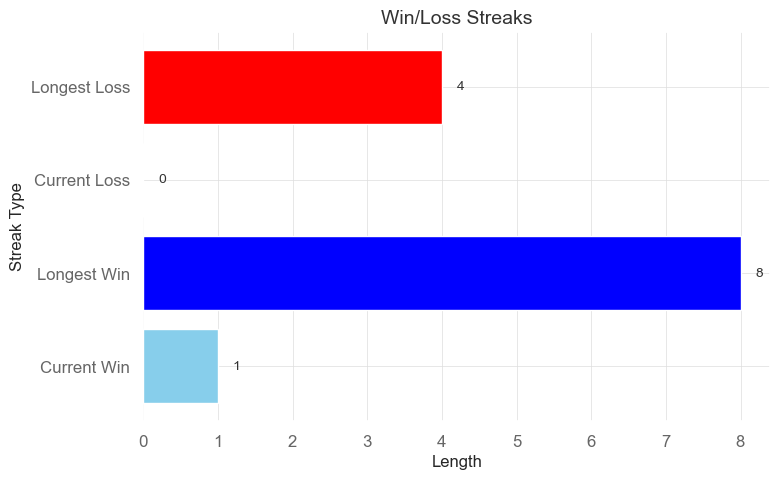

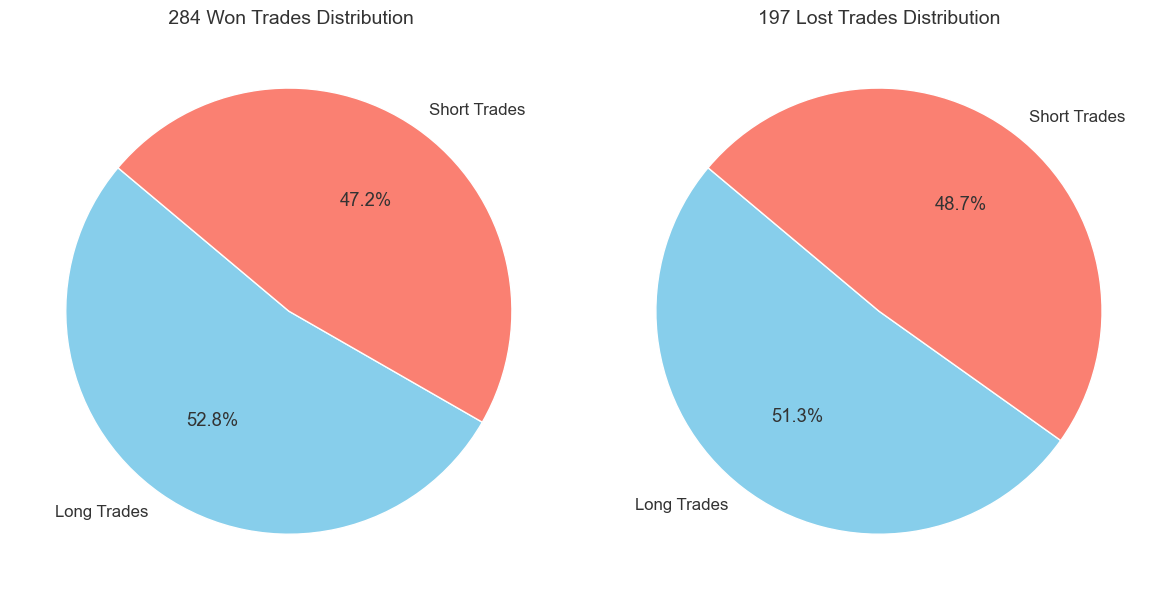

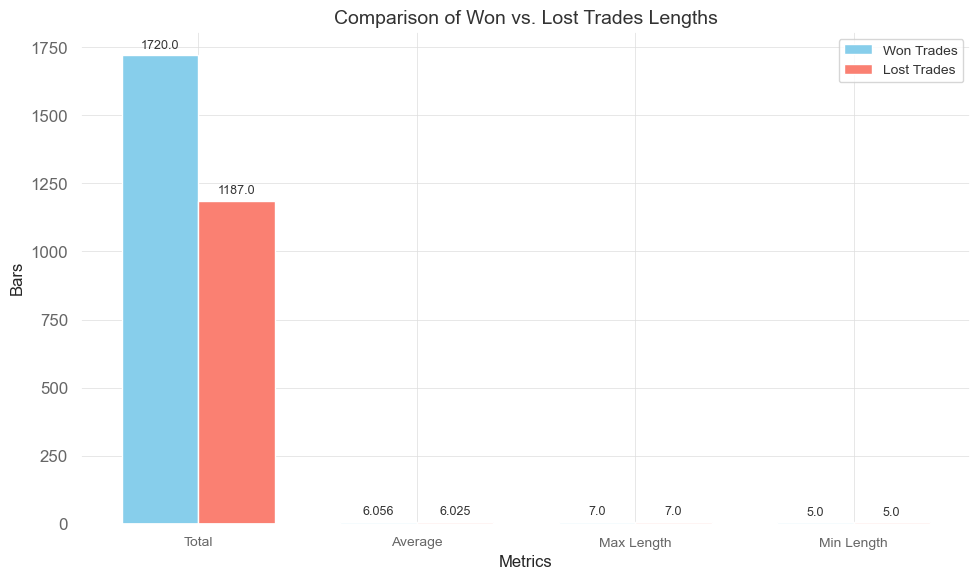

Max Drawdown Duration without weekends and holidays (in bars): 7


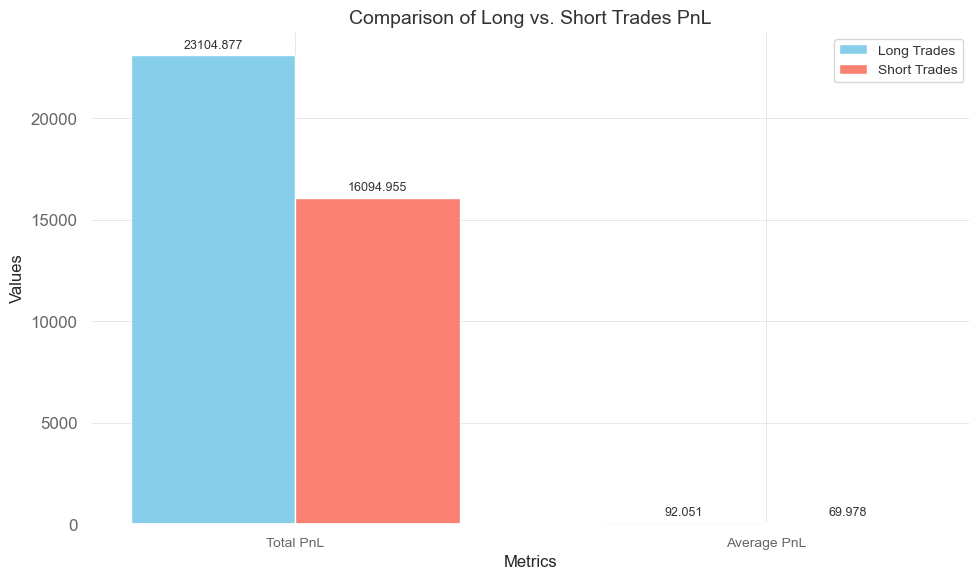

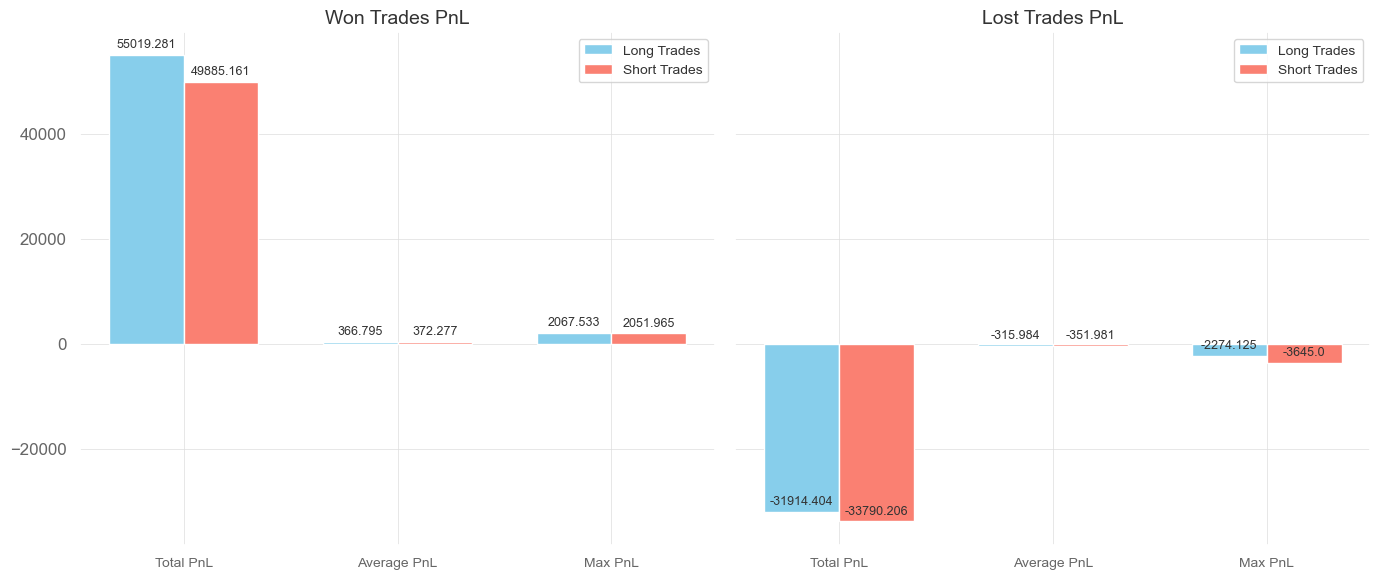

		Trade Statistics
************************************************************
Win Rate: 59.04%
Profit Factor: 1.596607019816237
Profit to Loss Ratio: 1.1075055736049249
Expectancy: 81.49653124509058
Risk to Reward Ratio: 1.762970877126557
Optimal fraction to bet: 74.675%
Perry Kaufman's Risk of Ruin: 60.547%
Ralph Vince's Risk of Ruin: 100.000%

		Monte Carlo Simulation
************************************************************
+------------------+--------------------------------------+-----------------------------+
| Confidence Level |            Net Profit CI             |      Max Drawdown % CI      |
+------------------+--------------------------------------+-----------------------------+
|      50.0%       | [31318.4532 - 31423.19 - 31527.9179] | [29.1936 - 29.47 - 29.7555] |
|      60.0%       | [31292.4934 - 31423.19 - 31553.8778] | [29.1240 - 29.47 - 29.8251] |
|      70.0%       | [31262.2270 - 31423.19 - 31584.1442] | [29.0428 - 29.47 - 29.9063] |
|      80.0%       | [31

In [23]:
try:
    # "args" can be a list of strings that will be parsed as command-line arguments ["--cash", "50000"]
    # can add sizer_class that extends bt.sizers or CustomSizer from MyBTclasses.py
    run_strategy(FlowTimingStrategy, args=["--genstats","--cash","10000","--commission","0","--slippage","0","--dataname", "TLT.csv","--sizer","percents=90"])
except Exception as e:
    exc_type, exc_obj, exc_tb = sys.exc_info()
    fname = traceback.extract_tb(exc_tb)[-1][0]
    line = traceback.extract_tb(exc_tb)[-1][1]
    print(f"Error: {e}")
    print(f"File: {fname}")
    print(f"Line: {line}")
    print("Full traceback:")
    traceback.print_exc()